In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


## 데이터 다운로드

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fd1646d28e0>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')


In [4]:
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수:', len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수: 50000


In [5]:
train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


시간이 오래 걸려서 일부 텍스트 데이터만 사용

In [19]:
train_data = train_data[:5000]

## 데이터 전처리

- 중복값, 결측치 제거
- 한글만 남기기
- 띄어쓰기 고치기
- 형태소 분석
- 한글자, 불용어 제거
- 최소 횟수 이하 단어 제거

In [20]:
train_data['document'].nunique(), train_data['label'].nunique()

(4974, 2)

전체 50000개 데이터 중 중복 제거한 샘플 49120개, label은 긍부정 2종류

In [21]:
# 중복 샘플 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 4974


In [22]:
# 결측치 확인
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [23]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [24]:
# 인덱스 재배치
train_data = train_data.reset_index(drop=True)

In [25]:
# 한글만 남기기
import re
def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

In [26]:
train_data['document'] = train_data['document'].apply(lambda x:extract_word(x))


In [27]:
! pip install git+https://github.com/ssut/py-hanspell.git


  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-o5vkmz8r
  Running command git clone --filter=blob:none -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-o5vkmz8r
  Resolved https://github.com/ssut/py-hanspell.git to commit fdc6ca50c19f1c85971437a072d89d4e5ce024b8
  Preparing metadata (setup.py) ... done


In [28]:
from hanspell import spell_checker

for i in range(len(train_data)):
    spelled_sent = spell_checker.check(train_data['document'][i])
    hanspell_sent = spelled_sent.checked
    train_data.loc[i, 'document'] = hanspell_sent
    
    if i%10 == 0:
        print(f'{i}번째 문장 완료!')

print(train_data[:10])


0번째 문장 완료!
10번째 문장 완료!
20번째 문장 완료!
30번째 문장 완료!
40번째 문장 완료!
50번째 문장 완료!
60번째 문장 완료!
70번째 문장 완료!
80번째 문장 완료!
90번째 문장 완료!
100번째 문장 완료!
110번째 문장 완료!
120번째 문장 완료!
130번째 문장 완료!
140번째 문장 완료!
150번째 문장 완료!
160번째 문장 완료!
170번째 문장 완료!
180번째 문장 완료!
190번째 문장 완료!
200번째 문장 완료!
210번째 문장 완료!
220번째 문장 완료!
230번째 문장 완료!
240번째 문장 완료!
250번째 문장 완료!
260번째 문장 완료!
270번째 문장 완료!
280번째 문장 완료!
290번째 문장 완료!
300번째 문장 완료!
310번째 문장 완료!
320번째 문장 완료!
330번째 문장 완료!
340번째 문장 완료!
350번째 문장 완료!
360번째 문장 완료!
370번째 문장 완료!
380번째 문장 완료!
390번째 문장 완료!
400번째 문장 완료!
410번째 문장 완료!
420번째 문장 완료!
430번째 문장 완료!
440번째 문장 완료!
450번째 문장 완료!
460번째 문장 완료!
470번째 문장 완료!
480번째 문장 완료!
490번째 문장 완료!
500번째 문장 완료!
510번째 문장 완료!
520번째 문장 완료!
530번째 문장 완료!
540번째 문장 완료!
550번째 문장 완료!
560번째 문장 완료!
570번째 문장 완료!
580번째 문장 완료!
590번째 문장 완료!
600번째 문장 완료!
610번째 문장 완료!
620번째 문장 완료!
630번째 문장 완료!
640번째 문장 완료!
650번째 문장 완료!
660번째 문장 완료!
670번째 문장 완료!
680번째 문장 완료!
690번째 문장 완료!
700번째 문장 완료!
710번째 문장 완료!
720번째 문장 완료!
730번째 문장 완료!
740번째 문장 완료!
750번째 문장 완료!
760번째 문장 완료!
770번째 문장 완

In [109]:
train_data.to_csv('train_data.txt', sep='\t', index=False)
train_data.to_csv('total_data.csv', sep='\t', index=False)

In [112]:
train_data = pd.read_csv('total_data.csv', sep='\t')
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0
1,3819312,흠 포스터 보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1
...,...,...,...
4969,7476802,별 개도 주기 아깝다 여자애 한 명을 두고 남자 둘의 싸움 내용임 그냥 소설다운 ...,0
4970,778724,포스님의 귀여운 연기 잘 봤어요 사고 때문에 중단돼서 아쉽네요,1
4971,10080330,그냥 영화인 거 같다 참고로 끝까지 봄,0
4972,6684036,나중이라도 꼭 한번 보고 싶습니다,1


### 데이터 분포 확인

   label  count
0      0   2493
1      1   2481


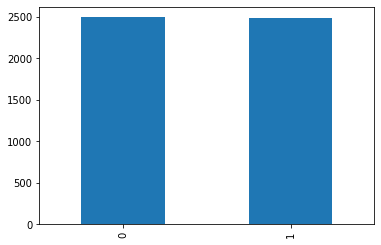

In [87]:
# 라벨 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

문장의 최단 길이: 1
문장의 최장 길이: 171
문장의 평균 길이: 37
Data Size: 4974


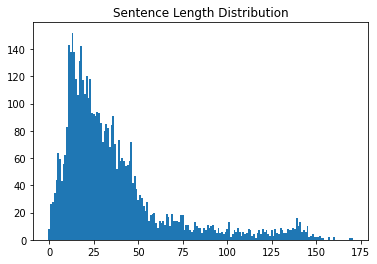

In [88]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

    
print("Data Size:", len(train_data))
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [89]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return


In [90]:
check_sentence_with_length(train_data['document'], 25)

소파에 죽치고 앉아 지켜볼 이유가 없는 작품 
강수연의 나가있어  그리고 최정원의 신 음식 
신나는 흑인음악과 아이스 큐브뿐 남는 게 없다
   영화 뭘 전달하려는지 모르겠네 오글거리고
네놈을 살려두기엔 쌀이 아까워  세기의 명대사
이 영화는 최고다  그냥 최고야 그런 줄 알아
진짜 어마어마한 여운을 주는 멜로 영화에요  
정말 완벽했다 최고의 영화 중에 꼽히는 영화 
후속 지금이라도 나와라 한국 애니 좀 살려보자
누구나  낄 수  너 덕을 영화화함   굿  
왠지 모를 색다른 감동을 주는 영화이다    
솔직히 평점  점 이상은 돼야 되는 거 같다 
배우들 연기력이 아깝다  별 한 개도 아깝다 
너무 재미있게 보았는데요 다시 볼 수 없을까요
폭력 영화  자극적이고 실험적이라고 예술인가 
당신이 솔로가 아니면 이 영화를 보지 마세요 
너무 구식으로 웃기려고 함  보는 내내 지겨움
나 홀로 집에 와 더불어 나의 최고의 영화  
의도는 좋지만 너무 몰입이 안 되는 걸 어떡해
설리   년생인데 연도 영화에 어떻게 나오죠 
영화는 안 보고 포스터만 봐도  점주기 아까움
퀸틴 타란티노의 포럼을 어쭙잖게 패러디한 졸작
물체가 움직이거나 어떤 일이 진행되는 빠르기 
음악밖에 기억 안 나    띠 띠디 띠    
내용 기대 없이 훈훈한 주인공 오빠 보기엔 굿
모로 보나 도로 보나  접대는 돼야 하는 영화
아 재밌다아 재밌다아 재밌다아 재밌다아 재밌다
너무 지루하다  솔직히  점은 너무 과대평가 
운지 운지 홍어 홍어 부릉부릉 땅크 나가신다 
진짜 핵노잼   번째 스트라이커가 차라리 낫다
독립영화의 진수를 보여주는 아주 감동적인 영화
초등학생 조카랑 보러 갔는데 재밌게 봤어요  
극장에서 봤어요 잔잔한 감동 좋았습니다    
 류 영화 베드신 하나 믿고 봤는데 캐실 망 
양조위랑 장첸은 뭔 상관이라는 거냐      
자극적인 장면을 넣는데만 애썼다    지루하다
참 저질스러운 영화 내 평가에 내가 놀란다  
동성애에 대한 편견과 불쾌감을 심어주는 영화 
쓰레기 중의 쓰레기 영

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 172
below_threshold_len(max_len, train_data)

## sentencepiece 모델 학습

In [114]:
# sentence piece에 사용하기 위해 txt 파일로 저장

file_path = './train_data.csv'

with open('train_data.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['document']))
    

In [116]:
spm.SentencePieceTrainer.Train('--input=train_data.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')


In [117]:
import csv

vocab_list = pd.read_csv('naver.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)


,0,1
765,▁독,-762
223,▁들,-220
3482,▁발톱,-3479
4152,격,-4149
4491,웨,-4488
457,▁손,-454
4216,갑,-4213
3688,어주는,-3685
2726,▁젤,-2723
1253,▁멜,-1250


In [118]:
len(vocab_list)

5000

In [126]:
data = pd.read_csv('total_data.csv', sep='\t')


In [127]:
data[:10]

,id,document,label
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0
1,3819312,흠 포스터 보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용 영화 별 반 개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지 못했다,0
7,9443947,별 반 개도 아깝다 욕 나온다 이응경 길용우 연기생활이 몇 년인지 정말 발로해도 ...,0
8,7156791,액션이 없는데도 재미있는 몇 안 되는 영화,1
9,5912145,왜 이렇게 평점이 낮은 건데 꽤 볼만한데 할리우드식 화려함에만 너무 길들여져 있나,1


### 토큰화 수행
- sentencepiece
- mecab
- kkma
- okt

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [130]:
# sentencepiece
spm_model = 'naver.model'
tokenizer_spm = spm.SentencePieceProcessor()
tokenizer_spm.Load(spm_model)
data['spm_tokens'] = [tokenizer_spm.EncodeAsIds(sentence) for sentence in data['document']]


In [133]:
# konlp: mecab, kkma, okt
from konlpy.tag import Mecab, Kkma, Okt

#mecab
tokenizer_mecab = Mecab()
data['mecab_tokens'] = [tokenizer_mecab.morphs(sentence) for sentence in data['document']]

#kkma
#tokenizer_kkma = Kkma()
#data['kkma_tokens'] = [tokenizer_kkma.morphs(sentence) for sentence in data['document']]

#okt
tokenizer_okt = Okt()
data['okt_tokens'] = [tokenizer_okt.morphs(sentence) for sentence in data['document']]


In [134]:
labels = train_data['label'].values


In [135]:

X_train, X_test, y_train, y_test = train_test_split(data[['spm_tokens', 'mecab_tokens', 'okt_tokens']], labels, test_size=0.2, random_state=42)


In [194]:
print(f'X_TRAIN:{len(X_train)}')
print(f'X_test:{len(X_test)}')
print(f'y_Train:{len(y_train)}')
print(f'y_Test:{len(y_test)}')

X_TRAIN:3979
X_test:995
y_Train:3979
y_Test:995


In [195]:
X_train[:5]

,spm_tokens,mecab_tokens,okt_tokens
1558,"[507, 96, 4341, 106, 511, 1331, 4, 2060, 575, ...","[뭔가, 미흡, 하, 다, 하, 지만, 프랑스, 영화, 다운로드, 은은, 한, 감동...","[뭔가, 미흡하다, 하지만, 프랑스, 영화, 다운로드, 은은한, 감동, 이, 묻어,..."
3460,"[2439, 1393, 30, 504, 759, 255, 116, 31, 132, ...","[꿈, 을, 통해, 만나, 는, 사람, 들, 이야기, 들, 이, 너무, 재미있, 었...","[꿈, 을, 통해, 만나는, 사람, 들, 이야기, 들, 이, 너무, 재미있었어요]"
4716,"[82, 1868, 4444, 3803, 3940, 496, 727, 1954, 7...","[이런, 핵폐기물, 막장, 시나리오, 쓰, 는, 놈, 은, 작가, 로서, 의, 자존...","[이런, 핵폐기물, 막장, 시나리오, 쓰는, 놈, 은, 작가, 로서, 의, 자존심,..."
4173,"[684, 3798, 3987, 2067, 133, 1263, 239]","[왕가위, 영화, 감독, 보, 는, 듯, 한, 느낌]","[왕가위, 영화감독, 보는듯, 한, 느낌]"
422,"[107, 766, 17, 2873]","[그냥, 둘, 다, 변태]","[그냥, 둘, 다, 변태]"


In [196]:
X_test[:5]

,spm_tokens,mecab_tokens,okt_tokens
721,"[399, 3806, 789, 120, 1203, 1630, 3802, 968, 3...","[결말, 의, 의미, 공자, 가, 자연, 에, 숨, 어, 사, 는, 노자, 에게, ...","[결말, 의, 의미, 공자, 가, 자연, 에, 숨어, 사는, 노자, 에게, 말, 했..."
144,"[132, 248, 209, 4265, 3789, 4188, 3796, 818]","[재미있, 다고, 허풍, 떨, 지, 마세요]","[재미있다고, 허풍, 떨지, 마세요]"
4542,"[877, 216, 467, 216, 1833, 2279, 2463, 4173, 1...","[감동, 도, 없, 고, 재미, 도, 없, 고, 무엇, 보다, 여기, 서, 류승범,...","[감동, 도, 없고, 재미, 도, 없고, 무엇, 보다, 여기, 서, 류승범, 조진웅..."
642,"[50, 192, 990, 184, 4, 204, 191, 184, 2032, 20...","[진짜, 이건, 아님, 액션, 영화, 좋, 아, 해서, 액션, 영화, 만, 다운로드...","[진짜, 이건, 아님, 액션, 영화, 좋아해서, 액션, 영화, 만, 다운로드, 해서..."
4808,"[214, 166, 80, 416, 463]","[편, 보다, 더, 스릴, 있, 다]","[편, 보다, 더, 스릴, 있다]"


In [197]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 정수인코딩 위한 토크나이저 생성
tokenizer_spm = Tokenizer()
tokenizer_mecab = Tokenizer()
tokenizer_okt = Tokenizer()

# 피처 데이터 학습
tokenizer_mecab.fit_on_texts(X_train['mecab_tokens'])
tokenizer_okt.fit_on_texts(X_train['okt_tokens'])

# train_Data
# 정수인코딩
X_train_spm_indices = X_train['spm_tokens']
X_train_mecab_indices = tokenizer_mecab.texts_to_sequences(X_train['mecab_tokens'])
X_train_okt_indices = tokenizer_okt.texts_to_sequences(X_train['okt_tokens'])

# 패딩
max_seq_length = 172
X_train_spm_pad = pad_sequences(X_train_spm_indices, maxlen=max_seq_length, padding='pre')
X_train_mecab_pad = pad_sequences(X_train_mecab_indices, maxlen=max_seq_length, padding='pre')
X_train_okt_pad = pad_sequences(X_train_okt_indices, maxlen=max_seq_length, padding='pre')

# test_data
# 정수인코딩
X_test_spm_indices = X_test['spm_tokens']
X_test_mecab_indices = tokenizer_mecab.texts_to_sequences(X_test['mecab_tokens'])
X_test_okt_indices = tokenizer_okt.texts_to_sequences(X_test['okt_tokens'])

# 패딩
max_seq_length = 172
X_test_spm_pad = pad_sequences(X_test_spm_indices, maxlen=max_seq_length, padding='pre')
X_test_mecab_pad = pad_sequences(X_test_mecab_indices, maxlen=max_seq_length, padding='pre')
X_test_okt_pad = pad_sequences(X_test_okt_indices, maxlen=max_seq_length, padding='pre')


In [198]:
X_train_okt_pad[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [199]:
print(f'train_spm:{len(X_train_spm_pad)}')
print(f'train_mecab:{len(X_train_mecab_pad)}')
print(f'train:okt:{len(X_train_okt_pad)}')
print("---------------------------")
print(f'test_spm:{len(X_test_spm_pad)}')
print(f'test_mecab:{len(X_test_mecab_pad)}')
print(f'test:okt:{len(X_test_okt_pad)}')
print("-------------------------")
print(f'y_Train:{len(y_train)}')
print(f'y_Test:{len(y_test)}')

train_spm:3979
train_mecab:3979
train:okt:3979
---------------------------
test_spm:995
test_mecab:995
test:okt:995
-------------------------
y_Train:3979
y_Test:995


## 모델 생성 및 학습

In [254]:
def build_model():
    embedding_dim = 100
    model = Sequential([
        Embedding(input_dim=172, output_dim=embedding_dim, input_length=max_seq_length),
        LSTM(units=128),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model


In [255]:
spm_model = build_model()
mecab_model = build_model()
okt_model = build_model()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 172, 100)          17200     
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 134,577
Trainable params: 134,577
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 172, 100)          17200     
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               117248    
________________________

In [251]:
len(X_train_spm_pad)

3979

In [256]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
mc = ModelCheckpoint('best_spm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_spm = spm_model.fit(X_train_spm_pad, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping,])


Epoch 1/200
50/50 [==============================] - 3s 20ms/step - loss: 0.6899 - acc: 0.5344 - val_loss: 0.6780 - val_acc: 0.5741
Epoch 2/200
50/50 [==============================] - 1s 11ms/step - loss: 0.7123 - acc: 0.6111 - val_loss: 0.6380 - val_acc: 0.6068
Epoch 3/200
50/50 [==============================] - 1s 11ms/step - loss: 0.6424 - acc: 0.6359 - val_loss: 0.6250 - val_acc: 0.6256
Epoch 4/200
50/50 [==============================] - 1s 11ms/step - loss: 0.6184 - acc: 0.6447 - val_loss: 0.6257 - val_acc: 0.6106
Epoch 5/200
50/50 [==============================] - 1s 11ms/step - loss: 0.6127 - acc: 0.6500 - val_loss: 0.6227 - val_acc: 0.6118
Epoch 6/200
50/50 [==============================] - 1s 12ms/step - loss: 0.6150 - acc: 0.6532 - val_loss: 0.6226 - val_acc: 0.6231
Epoch 7/200
50/50 [==============================] - 1s 11ms/step - loss: 0.6054 - acc: 0.6478 - val_loss: 0.6451 - val_acc: 0.6143
Epoch 8/200
50/50 [==============================] - 1s 11ms/step - loss: 0.

In [257]:
spm_model.evaluate(X_test_spm_pad, y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.6528 - acc: 0.6080


[0.652755856513977, 0.6080402135848999]

In [259]:
history_mecab = mecab_model.fit(X_train_mecab_pad, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping, mc])
mecab_model.evaluate(X_test_mecab_pad, y_test)


Epoch 1/200
50/50 [==============================] - 3s 29ms/step - loss: 0.7104 - acc: 0.6287 - val_loss: 0.5853 - val_acc: 0.6935

Epoch 00001: val_acc improved from -inf to 0.69347, saving model to best_spm.h5
Epoch 2/200
50/50 [==============================] - 1s 11ms/step - loss: 0.5672 - acc: 0.7103 - val_loss: 0.5410 - val_acc: 0.7261

Epoch 00002: val_acc improved from 0.69347 to 0.72613, saving model to best_spm.h5
Epoch 3/200
50/50 [==============================] - 1s 11ms/step - loss: 0.5118 - acc: 0.7374 - val_loss: 0.5488 - val_acc: 0.6872

Epoch 00003: val_acc did not improve from 0.72613
Epoch 4/200
50/50 [==============================] - 1s 11ms/step - loss: 0.4970 - acc: 0.7408 - val_loss: 0.5355 - val_acc: 0.6997

Epoch 00004: val_acc did not improve from 0.72613
Epoch 5/200
50/50 [==============================] - 1s 11ms/step - loss: 0.4896 - acc: 0.7433 - val_loss: 0.5314 - val_acc: 0.7186

Epoch 00005: val_acc did not improve from 0.72613
Epoch 6/200
50/50 [===

[0.5087105631828308, 0.7407035231590271]

In [260]:
history_okt = okt_model.fit(X_train_okt_pad, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping, mc])
okt_model.evaluate(X_test_okt_pad, y_test)


Epoch 1/200
50/50 [==============================] - 8s 79ms/step - loss: 0.6769 - acc: 0.5866 - val_loss: 0.6348 - val_acc: 0.6520

Epoch 00001: val_acc did not improve from 0.73116
Epoch 2/200
50/50 [==============================] - 1s 13ms/step - loss: 0.6581 - acc: 0.6704 - val_loss: 0.5846 - val_acc: 0.6696

Epoch 00002: val_acc did not improve from 0.73116
Epoch 3/200
50/50 [==============================] - 1s 11ms/step - loss: 0.5619 - acc: 0.6965 - val_loss: 0.5788 - val_acc: 0.6734

Epoch 00003: val_acc did not improve from 0.73116
Epoch 4/200
50/50 [==============================] - 1s 11ms/step - loss: 0.5493 - acc: 0.6987 - val_loss: 0.5723 - val_acc: 0.6721

Epoch 00004: val_acc did not improve from 0.73116
Epoch 5/200
50/50 [==============================] - 1s 11ms/step - loss: 0.5403 - acc: 0.7085 - val_loss: 0.5707 - val_acc: 0.6696

Epoch 00005: val_acc did not improve from 0.73116
Epoch 6/200
50/50 [==============================] - 1s 11ms/step - loss: 0.5673 - ac

[0.5855572819709778, 0.6743718385696411]

In [275]:
def eval_model(model, name, X_test_pad):    
    y_pred = model.predict(X_test_pad)
    y_pred = [1 if val > 0.5 else 0 for val in y_pred]
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} : {accuracy:.4f}")

In [277]:
eval_model(spm_model, "spm", X_test_spm_pad)
eval_model(okt_model, "okt", X_test_okt_pad)
eval_model(mecab_model, "mecab", X_test_mecab_pad)

Accuracy of spm : 0.6080
Accuracy of okt : 0.6744
Accuracy of mecab : 0.7407


mecab이 0.7407로 testset기준 성능이 제일 높다

In [282]:
history_mecab.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

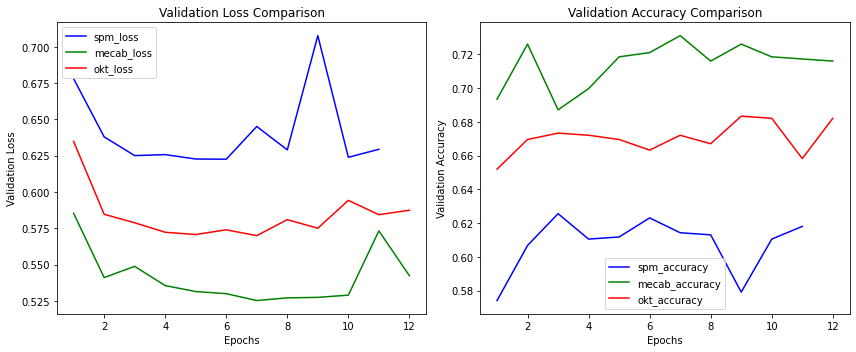

In [290]:
import matplotlib.pyplot as plt

# 모델 히스토리에서 'val_loss'와 'val_accuracy' 값 추출
model1_history = history_spm.history
model2_history = history_mecab.history
model3_history = history_okt.history

# epoch 수 (x축) 생성
epochs_model1 = range(1, len(model1_history['val_loss']) + 1)
epochs_model2 = range(1, len(model2_history['val_loss']) + 1)
epochs_model3 = range(1, len(model3_history['val_loss']) + 1)

# 그래프 크기 설정
plt.figure(figsize=(12, 5))

# 첫 번째 subplot: Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_model1, model1_history['val_loss'], 'b', label='spm_loss')
plt.plot(epochs_model2, model2_history['val_loss'], 'g', label='mecab_loss')
plt.plot(epochs_model3, model3_history['val_loss'], 'r', label='okt_loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# 두 번째 subplot: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_model1, model1_history['val_acc'], 'b', label='spm_accuracy')
plt.plot(epochs_model2, model2_history['val_acc'], 'g', label='mecab_accuracy')
plt.plot(epochs_model3, model3_history['val_acc'], 'r', label='okt_accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# 그래프 보여주기
plt.tight_layout()
plt.show()
